# Code Assignment 17 — K-Means Model Comparison with CH & DB + Assumption Testing (Mall Customers)

**Format:** Instructor Guidance → Your Task (step-by-step) → We Share (reflection)

**Goal:**  Compare **two feature sets** for K-Means at the **same K**:  
- **Model 1:** 2 features → `['Annual Income (k$)', 'Spending Score (1-100)']`  
- **Model 2:** 3 features → `['Age', 'Annual Income (k$)', 'Spending Score (1-100)']`  
Evaluate with **Silhouette (↑), Calinski–Harabasz (↑), Davies–Bouldin (↓)**, **separation ratio** (↑), **cluster sizes**, and **stability (median ARI) (↑)**.



## Instructor Guidance (Pseudocode + Docs)

**Docs**  
- `StandardScaler`: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html  
- `KMeans`: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html  
- `silhouette_score`: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html  
- `calinski_harabasz_score`: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html  
- `davies_bouldin_score`: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html  
- `adjusted_rand_score` (stability): https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

### Pseudocode Plan (Model Comparison)
  1) Load CSV → pick clean numeric columns (2D vs 3D).  
  2) **Scale** each feature set **separately** with `StandardScaler`.  
  3) Fix **K** (e.g., K=4).  
  4) Fit KMeans on each set → get labels & centers.  
  5) Compute metrics: `silhouette_score` (↑), `calinski_harabasz_score` (↑), `davies_bouldin_score` (↓).  
  6) Assumption checks: **separation ratio** (min between-centroid distance ÷ max within-cluster spread), **cluster sizes** (%), **stability via ARI** across seeds.  
  7) Compare models in a table → pick one and justify.


## Your Task — Step-by-Step
Work in pairs. Keep it minimal and clear.

### 0) Run Helper Functions and do your Imports

In [132]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

In [133]:
# RUN THIS CELL WITHOUT CHANGES 

def cluster_size_pct(labels):
    """Return % size of each cluster (sorted by cluster index)."""
    s = pd.Series(labels).value_counts(normalize=True).sort_index()
    return (s * 100).round(1)

def within_between_ratio(Z, labels, centers):
    """
    Heuristic separation metric:
    min distance among centroids ÷ max within-cluster spread (avg feature std per cluster).
    Higher is better (more separated vs within spread).
    """
    within = []
    for c in range(centers.shape[0]):
        pts = Z[labels == c]
        if len(pts) == 0:
            within.append(np.nan)
        else:
            within.append(pts.std(axis=0).mean())
    within = np.array(within, dtype=float)
    max_within = np.nanmax(within)

    D = cdist(centers, centers)  # centroid distance matrix
    np.fill_diagonal(D, np.nan)
    min_between = np.nanmin(D)
    return float(min_between / max_within)

def stability_ari(Z, k, seeds=(0, 1, 2, 3, 4)):
    """
    Fit KMeans across multiple seeds and compute median Adjusted Rand Index across pairs.
    Higher median ARI = more stable clustering to initialization.
    """
    label_sets = []
    for s in seeds:
        km = KMeans(n_clusters=k, n_init=10, random_state=s).fit(Z)
        label_sets.append(km.labels_)
    pairs = [(i, j) for i in range(len(label_sets)) for j in range(i+1, len(label_sets))]
    aris = [adjusted_rand_score(label_sets[i], label_sets[j]) for (i, j) in pairs]
    return float(np.median(aris))


### 1) Load the Mall Customers CSV & Preview
Use the same dataset as last time.

In [134]:
df = pd.read_csv("/Users/Marcy_Student/Desktop/Marcy_Lab/DA2025_Lectures/Mod6/data/Mall_Customers copy.csv")

In [135]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


### 2) Build 2D and 3D feature sets (numeric only, minimal cleaning)

- 2D set:  Annual Income and Spending Score
- 3D set:  Age, Annual Income, Spending Score 

**Be sure to scale!**


In [137]:
X_A = df[['Age', 'Annual Income (k$)','Spending Score (1-100)']]
X_B = df[['Annual Income (k$)', 'Spending Score (1-100)']]

In [138]:
# Let's scale the data before clustering
scaler = StandardScaler()
X_A_scaled = scaler.fit_transform(X_A)
X_B_scaled = scaler.fit_transform(X_B)

### 3) Choose a single k for BOTH models (you can try 3, 4, 5, etc.)

In [139]:
K_FIXED = 3
print('Using K =', K_FIXED)

Using K = 3


### 4) Fit Model 1 (2D @ K) and compute metrics

- No train-test split needed 
- Use helper functions above to help calculate metrics!


In [140]:
kmeans = KMeans(n_clusters=K_FIXED, random_state=0, n_init=10)
kmeans.fit(X_A_scaled)

KMeans(n_clusters=3, n_init=10, random_state=0)

In [141]:
sil, ch, db = [], [], []
labels = kmeans.labels_
sil.append(silhouette_score(X_A_scaled,labels=labels))
ch.append(calinski_harabasz_score(X_A_scaled,labels=labels))
db.append(davies_bouldin_score(X_A_scaled,labels=labels))

In [142]:
print(f"Silhouette (↑):  {sil[0]}\nCalinski–Harabasz (↑): {ch[0]}\nDavies–Bouldin (↓): {db[0]}")

Silhouette (↑):  0.357793388710272
Calinski–Harabasz (↑): 101.6949470919303
Davies–Bouldin (↓): 1.050270139649266


### 5) Fit Model 2 (3D @ K) and compute metrics

- No train-test split needed 
- Use helper functions above to help calculate metrics!
- Use same k as Model 1

In [143]:
kmeans_B = KMeans(n_clusters=K_FIXED, random_state=0, n_init=10)
kmeans_B.fit(X_B_scaled)

KMeans(n_clusters=3, n_init=10, random_state=0)

In [144]:
sil_B, ch_B, db_B = [], [], []
labels_B = kmeans_B.labels_
sil_B.append(silhouette_score(X_B_scaled,labels=labels_B))
ch_B.append(calinski_harabasz_score(X_B_scaled,labels=labels_B))
db_B.append(davies_bouldin_score(X_B_scaled,labels=labels_B))

In [145]:
print(f"Silhouette model 2(↑):  {sil_B[0]}\nCalinski–Harabasz model 2(↑): {ch_B[0]}\nDavies–Bouldin model 2(↓): {db_B[0]}")

Silhouette model 2(↑):  0.46658474419000145
Calinski–Harabasz model 2(↑): 151.33512126359477
Davies–Bouldin model 2(↓): 0.716482156943549


In [148]:
# within spread (avg feature std per cluster)
# get centers from the fitted kmeans (Model 1)
centers = kmeans.cluster_centers_

within = [X_A_scaled[labels == c].std(axis=0).mean() for c in range(K_FIXED)]
max_within = float(np.nanmax(within))

# Between-centroid distances
D = cdist(centers, centers)
np.fill_diagonal(D, np.nan)
min_between = float(np.nanmin(D))

sep_ratio = min_between / max_within if max_within > 0 else np.nan
print(f'Separation ratio = {sep_ratio:.2f} (Higher is better!)')

Separation ratio = 2.72 (Higher is better!)


### 6) Visualize Model 1 (2D Scatter Plot)


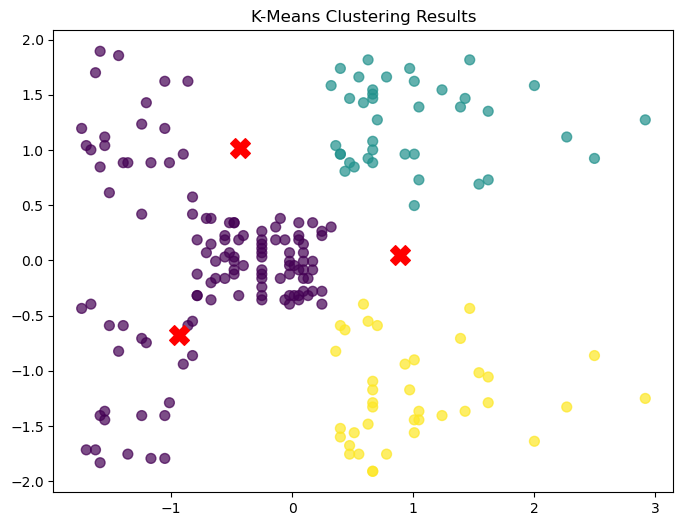

In [147]:

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_B_scaled[:, 0], X_B_scaled[:, 1], c=labels_B, cmap='viridis', s=50, alpha=0.7)
# Plot the centroids (the cluster centers) as red 'X's
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X')
plt.title('K-Means Clustering Results')
plt.show()

## We Share — Reflection (short, specific)
1) **Which model is better and why?** Reference **Sil (↑), CH (↑), DB (↓)**, **separation ratio (↑)**, **stability ARI (↑)**, and **cluster sizes**.  
- I chose the 3D model because it has the best performance based on its metrics. The 3D models has a higher silhouette and calinski-harabas score than the 2D model wich means that the clusters are well separated and not likely to overlap, also it means the clusters are dense, and clearly structured around the centroid. furthermore, the DB is between 0 and 1 lower than the 2D model meaning the ratio of each cluster spread to distance between other clusters are less likely to overlap.

2) **Assumptions & ethics:** Did your chosen model show **non-overlapping, roughly spherical, similarly dense** clusters? If not, what risk could that pose to stakeholders (mis-targeted offers, unfair treatment)? 
- My chosen model shows almost clusters that don't likely overlap, meaning that it is correctly doing the separation between the 3 features, but there clusters are all so close together. It is not perfoming at its best to recognize and differenciate the features. That can affect directly stakeholders business decisions as the model can misslead and give a wrong recommandation. For instance, if the 2 clusters are not well separated, high value custumer can be confuse to lower value customer, as a result get a wrong promotion or a low-value offer. Also, the stakeholders can lose their confidence or trust the segmentations strategy used by the analyst (aka Ibrahima 🤓)

3) **Next step:** If you had to ship this, what monitoring would you add (e.g., re-check metrics quarterly, watch for tiny cluster drift, re-scale after schema changes)?
- Before shipping this model to stakeholders, I'd recalculate the metrics like the silhouette score, Davies–Bouldin Score, and Calinski–Harabasz Score to make sure that the no cluster overlap to each other. Also that can help me find the reason why or when the model overlap maybe due to other factors(customer behavior, seasonality)

> Tip: If metrics conflict (e.g., CH prefers K=6, DB prefers K=4), prefer **parsimonious K** with **clear separation**, **stable labels**, and **business actionability**.
